In [1]:
from pandas_datareader import data
from datetime import datetime
import tensorflow as tf
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from io import BytesIO

from tensorflow.keras import datasets, layers, models, losses
from tensorflow.python.keras.utils import losses_utils
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Model

In [19]:
#now=datetime.now()

In [20]:
#df=data.DataReader('BTC-USD','yahoo','2019-4-23',now)
#df

In [21]:
#df.tail()
#df['Close'].plot()

In [22]:
#start=datetime(now.year-2,now.month,now.day,now.hour)

In [23]:
#tickers=['FB','AMZN','AAPL','GOOG','NFLX']
#profolio=data.DataReader(tickers,'yahoo',start,now)

In [24]:
#profolio['Close']
#profolio['Close'].plot()
#profolio['Close'].pct_change()
#profolio['Close'].pct_change().corr()

In [25]:
x_year_b4 = 4
now = datetime.now()
start = datetime(now.year-x_year_b4,now.month,now.day,now.hour)

In [26]:
ticker = 'NVDA'
#profolio=data.DataReader(tickers,'yahoo',start,now).drop(columns=['Adj Close'])
df = data.DataReader(ticker,'yahoo',start,now).drop(columns=['Adj Close']).drop(columns=['Volume'])


In [27]:
#size_ratio = 1
#x_scaled = np.multiply(x_scaled, size_ratio)
#df = pd.DataFrame(x_scaled)

In [28]:
day = 10
factors = 4
steps = 1
epochs = 20

df2 = df[:day].to_numpy()
df2 = np.reshape(df2,(day*factors))
dataset = df2
length = df.shape[0]

for row in range(1,df.shape[0]-day):
    df2 = df[row:row+day].to_numpy()
    df2 = np.reshape(df2,(day*factors))
    dataset = np.append(dataset,df2)

dataset = np.reshape(dataset,(-1,day,factors))


In [29]:
scaler = preprocessing.MinMaxScaler()

for row in range(dataset.shape[0]):
    dataset[row] = scaler.fit_transform(dataset[row])
    
#dataset

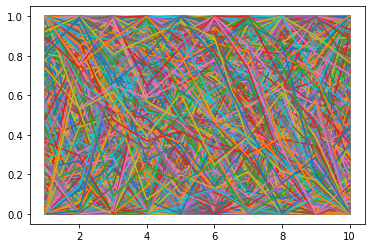

In [36]:
graph_data = []
buffer = BytesIO()


for row in range(dataset.shape[0]):
    x = np.arange(1,day+1)
    y = dataset[row]
    plt.plot(x,y)
    plt.savefig(buffer, format='jpg')
    buffer.seek(0)
    y = plt.imread(buffer, format='jpg')
    y = np.array(y)
    x = np.zeros((y.shape[0],y.shape[1]))
    
    for row in range(y.shape[0]):
        for col in range(y.shape[1]):
            if (np.sum(y[row,col]) != 255*3):
                x[row,col] = 1
    
    graph_data = np.append(graph_data,[x])
                                      
graph_data = np.reshape(graph_data, (-1, 288, 432))
dataset = graph_data
buffer.close()

In [37]:
np.save(r'C:\Users\carlos\Documents\coding\algo trade\model 2\processed_dataset.npy',dataset)

In [2]:
dataset = np.load(r'C:\Users\carlos\Documents\coding\algo trade\model 2\processed_dataset.npy')

In [3]:
#data matrix transposed

In [4]:
#normalizer = tf.keras.layers.Normalization(axis=-1)
#normalizer.adapt(np.array(dataset))

In [5]:
day = 10
factors = 4
steps = 1
epochs = 20

length = dataset.shape[0]
length

998

In [6]:
if steps == 1:
    train_dataset = dataset[:int(length*0.8)]
    test_dataset = dataset[int(length*0.8):]
    train_f = train_dataset[:-1]
    train_l = train_dataset[1:]
    test_f = test_dataset[:-1]
    test_l = test_dataset[1:]

In [7]:
train_l.shape

(797, 288, 432)

In [8]:
class forecasting(Model):
  def __init__(self):
    super(forecasting, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(288, 432, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='valid', strides=1),
      #layers.MaxPooling2D(pool_size=(2,2))
      layers.Conv2D(32, (3, 3), activation='relu', padding='valid', strides=1),
      layers.Conv2D(64, (3, 3), activation='relu', padding='valid', strides=1)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(64, kernel_size=3, strides=1, activation='relu', padding='valid'),
      layers.Conv2DTranspose(32, kernel_size=3, strides=1, activation='relu', padding='valid'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=1, activation='relu', padding='valid'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')
      ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = forecasting()

In [9]:
#autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [10]:
autoencoder.compile(optimizer='adam', loss="mean_squared_logarithmic_error")

In [11]:
#autoencoder.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [ ]:
autoencoder.fit(train_f, train_l,
                epochs=epochs,
                batch_size=100,
                shuffle=True,
                validation_data=(test_f, test_l))

In [ ]:
autoencoder.save(r'C:\Users\carlos\Documents\coding\algo trade\model 2\autoencoder')

In [ ]:
#autoencoder = tf.keras.models.load_model(r'C:\Users\carlos\Documents\coding\algo trade\model 2\autoencoder')

In [ ]:
autoencoder.encoder.summary()

In [ ]:
autoencoder.decoder.summary()

In [ ]:
#encoded_frame = autoencoder.encoder(test_f).numpy()
#decoded_frame = autoencoder.decoder(encoded_frame).numpy()

In [ ]:
input_data = dataset[dataset.shape[0]-1]
encoded_frame = autoencoder.encoder(input_data).numpy()
decoded_frame = autoencoder.decoder(encoded_frame).numpy()
decoded_frame

In [ ]:
while False:
    frame_no = decoded_frame.shape[0]-1
    five_days_prediction = []

    for num in range (day):
        for index in range (factors):
            diff = df_raw.max()[index] - df_raw.min()[index]
            mini = df_raw.min()[index]

            x = decoded_frame[frame_no, num, index]
            k = x * diff + mini

            five_days_prediction = np.append(five_days_prediction, k)